<a href="https://colab.research.google.com/github/smoralesc91/NMR_FEM/blob/main/Codes/FEM_NvsCvsA_ver1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMR: FEM, Conventional and Analytical

## FEM

\begin{equation}
\frac{\partial m}{\partial t} = \nabla \cdot (D \cdot \nabla m) - \frac{m}{T_{2B}}
\end{equation}

\begin{equation}
m_0 = m_s
\end{equation}

\begin{equation}
n \cdot (D \cdot \nabla m) + \rho m = 0
\end{equation}


\begin{equation}
M(t) = \int_V m \, dV
\end{equation}

simplifiying by simmetry in case for a sphere, in spherical coordinates the Laplace operator in 1D is:
\begin{equation}
	\nabla^2 f = 	\frac{\partial^2 f}{\partial r^2} + \frac{2}{r} \frac{\partial f}{\partial r}
\end{equation}
therefore, BT equation is:
\begin{equation}
\frac{\partial m}{\partial t} = D \frac{\partial^2 m}{\partial r^2} + D \frac{2}{r} \frac{\partial m}{\partial r} + \frac{m}{T_{2B}}
\end{equation}

\begin{equation}
M(t) = \int_0^{r^\prime} 4 \pi r^2 m(r, t)  dr
\end{equation}

Applying an implicit scheme in time, multipying by a weight function and integer over the domain, the weak form for the bilineal (a(u, w)) and lineal form (L(w)) are:
\begin{equation}
a(m, w) =  \int_{\Omega} m^n w dx + \Delta t \int_\Omega D \nabla m \cdot \nabla w dx + \Delta t \int_{\partial_R \Omega} \rho m w dx - \Delta t \int_\Omega D \frac{2}{r} \frac{\partial m}{\partial r} w dx + \Delta t \int_\Omega \frac{m}{T_{2B}}w dx
\end{equation}
\begin{equation}
L(w) = \int_{\Omega} m^{n-1} w dx
\end{equation}

## Conventional

\begin{equation}
M(t) = m(0) e^{-t/T_{2}^*}
\end{equation}

\begin{equation}
m(0) = m_s V
\end{equation}

\begin{equation}
T_{2}^* = T_{2B} + \frac{V}{\rho S}
\end{equation}

## Analytical

\begin{equation}
M(t) = m(0) \sum_{n=0}^\infty I_n e^{-t(\frac{1}{Tn}+\frac{1}{T_{2B}})}
\end{equation}

\begin{equation}
m(0) = m_s V
\end{equation}

\begin{equation}
T_n = \frac{r^2}{D \varepsilon^2_n}
\end{equation}

\begin{equation}
1 - \varepsilon_n \cot (\varepsilon_n) = \frac{r \rho}{D}
\end{equation}

\begin{equation}
I_n = \frac{12 [\sin (\varepsilon_n) - \varepsilon_n \cos (\varepsilon_n)]^2}{\varepsilon^3_n [2 \varepsilon_n - \sin(2 \varepsilon_n)]}
\end{equation}

# Libraries

In [ ]:
import platform, sys, os, shutil
import packaging.version as pv
import time

try:
    from google.colab import files
except:
    print("This is not google.colab")

python_version=platform.python_version()
print('python version:', python_version)

if pv.parse(python_version) < pv.parse("3.0.0"):
    print("Python3 is needed!")
    print("How to fix: Runtime/Change_runtime_type/Python 3")
    sys.exit()

try:
    from dolfin import *
    from dolfin import __version__ as dolfin_version
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import __version__ as mpl_version
    from tqdm import tqdm
    import scipy.optimize as opt
    from scipy.stats import norm
    from scipy.integrate import quad
    from scipy import __version__ as sp_version
    import mpmath
    import mshr
except ImportError as e:
    !wget  "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    from dolfin import *
    from dolfin import __version__ as dolfin_version
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import __version__ as mpl_version
    from tqdm import tqdm
    import scipy.optimize as opt
    from scipy.stats import norm
    from scipy.integrate import quad
    from scipy import __version__ as sp_version
    import mpmath
    import mshr

try:
  import gmsh
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
  import gmsh

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rc('lines', linewidth=2)

import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output, display

set_log_level(30)

print('numpy version:', np.__version__)
print('scipy version:', sp_version)
print('matplotlib version:', mpl_version)
print('dolfin version:', dolfin_version)
print('gmsh version:', gmsh.__version__)
print('mpmath version:', mpmath.__version__)


if os.path.exists('ILT.py'):
    %run ILT.py
    print('ILT.py load succesfully')
else:
    !wget "https://github.com/smoralesc91/NMR_FEM/raw/b5ef214434dfb1e440811921ba4f80b13177ef63/Codes/ILT.py"
    %run ILT.py
    print('ILT.py download and load succesfully')

This is not google.colab
python version: 3.10.12
numpy version: 1.26.4
scipy version: 1.12.0
matplotlib version: 3.5.1
dolfin version: 2019.2.0.13.dev0
gmsh version: 4.11.1
mpmath version: 1.2.1
ILT.py load succesfully


# Functions

In [ ]:
#Normalize results data
def normalize_results(data):
    data_max = np.max(np.abs(data))
    norm_data = data/data_max
    return norm_data

# Fit data
def T2star_fit(time_data, data):

    def exp_function(x, a, b):
        return a*np.exp(-x/b)

    t2star = opt.curve_fit(exp_function, time_data, data)
    return t2star[0][1]

# Calculating conventional T2star
def T2star_conventional(T2B, rho, SVratio):
    if T2B <= 0:
        T_2star = 1. / (rho * SVratio)
    else:
        T_2star = 1. / ((1. / T2B) + rho * SVratio)
    return T_2star

# Calculating analytical surface area and volume ratio
def SV_ratio_analytical(radius, aspect_ratio):
    if aspect_ratio == 1:
        S = 4. * np.pi * np.power(radius, 2)
        V = 4. * np.pi * np.power(radius, 3) / 3.
    else:
        a = radius
        b = radius*aspect_ratio
        c = radius*aspect_ratio
        S = 4. * np.pi * (((a * b) ** 1.6 + (a * c) ** 1.6 + (b * c) ** 1.6) / 3.) ** (1. / 1.6)
        V = 4. * np.pi * a * b * c / 3.

    SVratio = S / V
    return S, V, SVratio

# Brownstein-Tarr number
def BrownsteinTarr_number(r, rho, D, text=True):
    kappa = (r*rho) / D
    if kappa <= 1:
        kappa_regime = str('Fast diffusion')
        if text:
            print('Pore {:.2e} [m], Fast diffusion: {:.4f}'.format(r, kappa))
    elif 1 <= kappa <= 10:
        kappa_regime = str('Intermediate diffusion')
        if text:
            print('Pore {:.2e} [m], Intermediate diffusion: {:.4f}'.format(r, kappa))
    elif 10 <= kappa:
        kappa_regime = str('Slow diffusion')
        if text:
            print('Pore {:.2e} [m], Slow diffusion: {:.4f}'.format(r, kappa))
    return kappa, kappa_regime

# Absolute and relative error
def error_estimation(analytical_data, numerical_data):
    abs_error = abs(numerical_data - analytical_data)
    rel_error = abs_error/abs(analytical_data)
    return abs_error, rel_error

# Max T2 value ILT
def maxT2_ilt(x, y):
    index_max_y = np.argmax(y)
    max_y = y[index_max_y]
    x_position = x[index_max_y]
    return max_y, x_position

# Plot single graph
def plot_single_graph(xdata, ydata, label, title,
                     figsize, savefig=None):

    plt.figure(figsize=figsize)
    plt.plot(xdata, ydata, label=label)
    plt.legend()
    plt.title(title)

    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

# Plot dual graphs
def plot_dual_graphs(xdata1, ydata1, label1, title1,
                     xdata2, ydata2, label2, title2,
                     figsize, savefig=None):

    fig, axs = plt.subplots(1, 2, figsize=figsize)

    axs[0].plot(xdata1, ydata1, label=label1)
    axs[0].legend()
    axs[0].set_title(title1)
    axs[0].grid(True)

    axs[1].plot(xdata2, ydata2, label=label2)
    axs[1].legend()
    axs[1].set_title(title2)
    axs[1].grid(True)

    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

# Plot tripe graphs
def plot_tripĺe_graphs(xdata1=None, ydata1=None, label1='data1', title1='figure1', xscale1='lineal',
                       xdata2=None, ydata2=None, label2='data2', title2='figure2', xscale2='lineal',
                       xdata3=None, ydata3=None, label3='data3', title3='figure3', xscale3='lineal',
                       figsize=(20,4), savefig=None):

    fig, axs = plt.subplots(1, 3, figsize=figsize)

    if xscale1 == 'lineal':
        axs[0].plot(xdata1, ydata1, label=label1)
    elif xscale1 == 'log':
        axs[0].semilogx(xdata1, ydata1, label=label1)
    axs[0].legend()
    axs[0].set_title(title1)
    axs[0].grid(True, which='both')

    if xscale2 == 'lineal':
        axs[1].plot(xdata2, ydata2, label=label2)
    elif xscale2 == 'log':
        axs[1].semilogx(xdata2, ydata2, label=label2)
    axs[1].legend()
    axs[1].set_title(title2)
    axs[1].grid(True, which='both')

    if xscale3 == 'lineal':
        axs[2].plot(xdata3, ydata3, label=label3)
    elif xscale3 == 'log':
        axs[2].semilogx(xdata3, ydata3, label=label3)
    axs[2].legend()
    axs[2].set_title(title3)
    axs[2].grid(True, which='both')

    plt.tight_layout()
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()

# FEM Inital condition: Msat

## Code

In [ ]:
def NMR_FEM(radius=1., aspect_ratio = 1, dimension=1, mesh_res=10,
            mesh_stats=False, mesh_load=None,       #mesh options, mesh_load must be a list (mesh, markers, subdomains)
            T2B=1., diffusion=1, rho=1,             #model parameters
            B_0=0.05, Temp=303.15, fluid='water',   #initial condition ms
            t_0=0, t_f=1, dt=0.1, print_time=False, #time parameters
            return_data='all'):                     #return data: 'all', 'mag_amounts', 'mag_assemble'

    if mesh_load:
        mesh = mesh_load[0]
        dx = Measure('dx', domain=mesh, subdomain_data=mesh_load[1])
        ds = Measure('ds', domain=mesh, subdomain_data=mesh_load[2])
    elif dimension == 1:
        mesh = UnitIntervalMesh(mesh_res)
        mesh.scale(radius)
        marker_sub = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

        class Boundary(SubDomain):
            def inside(self, x, on_boundary):
                tol = 1.e-14
                return on_boundary and abs(x[0]-radius) < tol

        boundary_ = Boundary()
        boundary_.mark(marker_sub, 1)
        dx = Measure('dx', domain=mesh)
        ds = Measure('ds', domain=mesh, subdomain_data=marker_sub)
    elif dimension == 2:
        mesh = UnitSquareMesh(mesh_res, mesh_res)
        mesh.scale(radius)
    else:  # dimension == 3
        domain = mshr.Ellipsoid(Point(0, 0, 0), 1, aspect_ratio, aspect_ratio)
        mesh = mshr.generate_mesh(domain, mesh_res)
        mesh.scale(radius)

    if not mesh_load and dimension > 1:
        dx = Measure('dx', domain=mesh)
        ds = Measure('ds', domain=mesh, subdomain_data=mesh)

    if mesh_stats:
        def mesh_statistics(mesh):
            if mesh.topology().dim() == 1:
                r2 = Expression('x[0]*x[0]', degree = 3)
                volume_mesh = assemble(Constant(4)*np.pi*r2*dx(mesh))
                surface_mesh = assemble(Constant(4)*np.pi*r2*ds(mesh))
            else:
                volume_mesh = assemble(Constant(1)*dx(mesh))
                surface_mesh = assemble(Constant(1)*ds(mesh))

            surface_volume_ratio = surface_mesh / volume_mesh

            print("|Mesh statistics|")
            print("|---------------|")
            print("|{:<20}| {:<10.4e}|".format("hmin", mesh.hmin()))
            print("|{:<20}| {:<10.4e}|".format("hmax", mesh.hmax()))
            print("|{:<20}| {:<10d}|".format("num. cells", mesh.num_cells()))
            print("|{:<20}| {:<10d}|".format("num. edges", mesh.num_edges()))
            print("|{:<20}| {:<10d}|".format("num. entities 0d", mesh.num_entities(0)))
            print("|{:<20}| {:<10d}|".format("num. entities 1d", mesh.num_entities(1)))
            print("|{:<20}| {:<10d}|".format("num. entities 2d", mesh.num_entities(2)))
            print("|{:<20}| {:<10d}|".format("num. entities 3d", mesh.num_entities(3)))
            print("|{:<20}| {:<10d}|".format("num. faces", mesh.num_faces()))
            print("|{:<20}| {:<10d}|".format("num. facets", mesh.num_facets()))
            print("|{:<20}| {:<10d}|".format("num. vertices", mesh.num_vertices()))
            print("|{:<20}| {:<10.4e}|".format("Volume", volume_mesh) + "[m^3]")
            print("|{:<20}| {:<10.4e}|".format("Surface area", surface_mesh) + "[m^2]")
            print("|{:<20}| {:<10.4e}|".format("Surface to Volume ratio", surface_volume_ratio) + "[m^-1]")
            print("|---------------|")
            print("|{:<20}| {:<10.4e}|".format("T2star conventional", T2star_conventional(T2B, rho, surface_volume_ratio)) + "[s]")
            print("|---------------|")

        mesh_statistics(mesh)

    # Calculating magnetic saturation (Curie's law)
    def mag_sat(B_0, Temp, fluid):
        avogadro_number = 6.0220e23
        h_planck = 6.626e-34
        k_boltzmann = 1.380e-23
        gamma = 267.5e6

        assert fluid in ['water', 'oil', 'gas']

        if fluid == 'water':
            number_hydrogen = 2.
            fluid_mol_weight = 18.0153e-3
            fluid_density = 9.97e2
        elif fluid == 'oil':
            number_hydrogen = 12.
            fluid_mol_weight = 72.151e-3
            fluid_density = 6.26e2
        elif fluid == 'gas':
            number_hydrogen = 4.
            fluid_mol_weight = 16.04e-3
            fluid_density = 6.56e-1

        proton_density = (number_hydrogen * avogadro_number * fluid_density) / fluid_mol_weight
        m_s = (proton_density * B_0 * (gamma**2) * (h_planck**2)) / (4. * k_boltzmann * Temp)
        return m_s

    # Define Finte Element, Function Space, Test function (weight function) and Trial function
    polynomial_degree = 2
    element  = FiniteElement(family='CG', cell=mesh.ufl_cell(),
                             degree=polynomial_degree, quad_scheme='default')

    V = FunctionSpace(mesh, element)
    m = TrialFunction(V)
    w = TestFunction(V)

    # Initial condition over the domain
    m_sat = mag_sat(B_0, Temp, fluid)
    m_0 = Constant(m_sat)
    m_init = Function(V)
    m_init.assign(m_0)

    # Identify mesh dimension
    dim = mesh.topology().dim()

    # Define Diffusion tensor
    if dim == 1:
        D = diffusion
    if dim == 2:
        D = as_matrix(((diffusion, 0),
                       (0, diffusion)))
    elif dim == 3:
        D = as_matrix(((diffusion, 0, 0),
                       (0, diffusion, 0),
                       (0, 0, diffusion)))

    # Bilinear a(u, w) and linear form L(w)
    if T2B <= 0:
        bulk_term = 0.
    else:
        bulk_term = dt * (Constant(1) / Constant(T2B)) * m * w * dx

    if dim == 1:
        r = Expression('sqrt(x[0]*x[0])', degree=2)
        r2 = r*r
        a = m*w*dx + dt*D*dot(grad(m),grad(w))*dx + dt*Constant(rho)*m*w*ds(1) - dt*D*Constant(2)/r*Dx(m,0)*w*dx + bulk_term
        #a = m*w*dx + dt*D*Dx(m,0)*Dx(w,0)*dx + dt*rho*m*w*ds(1) - dt*D*Constant(2)/r*Dx(m,0)*w*dx + bulk_term
    else:
        a = m*w*dx + dt*inner(dot(D, grad(m)), grad(w))*dx + dt*Constant(rho)*m*w*ds + bulk_term

    L = m_init*w*dx

    # Apply initial condition
    m = Function(V)
    m.assign(m_init)

    # Time array
    nt = int((t_f-t_0)/dt) + 1
    times = np.linspace(t_0, t_f, nt)

    # Save magnetization vector
    mag_amounts = np.zeros(nt)

    # Integer initial magnetization over the magentization vector
    if dim == 1:
        mag_amounts[0] = assemble(Constant(4)*np.pi*m*r2*dx)
    else:
        mag_amounts[0] = assemble(m*dx)

    # Solve the problem
    if print_time:
        for i, t in tqdm(enumerate(times[1:]), desc='Progress', total=nt-1):
            solve(a == L, m, solver_parameters={'linear_solver': 'umfpack'},
                             form_compiler_parameters={"optimize": True})

            # Integer over the domain
            if dim == 1:
                mag_amounts[i+1] = assemble(Constant(4)*np.pi*m*r2*dx)
            else:
                mag_amounts[i+1] = assemble(m*dx)

            m_init.assign(m)
    else:
        for i, t in enumerate(times[1:], 1):
            solve(a == L, m, solver_parameters={'linear_solver': 'umfpack'},
                             form_compiler_parameters={"optimize": True})

            # Integer over the domain
            if dim == 1:
                mag_amounts[i] = assemble(Constant(4)*np.pi*m*r2*dx)
            else:
                mag_amounts[i] = assemble(m*dx)

            m_init.assign(m)

    # Integer to obtain total magnetization M(t)
    if dim == 1:
        mag_assemble = assemble(Constant(4)*np.pi*m*r2*dx)
    else:
        mag_assemble = assemble(m*dx)

    if return_data == 'all':
        return times, m, mag_amounts, mag_assemble
    elif return_data == 'mag_assemble':
        return mag_assemble
    elif return_data == 'mag_amounts':
        return mag_amounts

## 1D test

In [ ]:
%%time

radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
B0 = 0.05
t0 = 0; tf = 30; dt = 1.e-3

times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=500,
                                                  mesh_stats=False, mesh_load=None,  #mesh options
                                                  T2B=T2bulk, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                  B_0=B0, Temp=303.15, fluid='water',    #initial condition ms
                                                  t_0=t0, t_f=tf, dt=dt, print_time=True, #time parameters
                                                  return_data='all',
                                                 )

T2fit_raw = T2star_fit(times_, mag_amounts_)

mag_amounts_norm = normalize_results(mag_amounts_)
T2fit_norm = T2star_fit(times_, mag_amounts_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

z_value, f_value= ilt(t=times_, F=mag_amounts_norm, bound=np.array([1.e-1, 1.e3]), Nz=128, alpha=0.01, normed=True)
amp_max, max_time = maxT2_ilt(z_value, f_value)

Progress: 100%|██████| 30000/30000 [03:37<00:00, 137.80it/s]


CPU times: user 3min 32s, sys: 6.93 s, total: 3min 39s
Wall time: 3min 40s


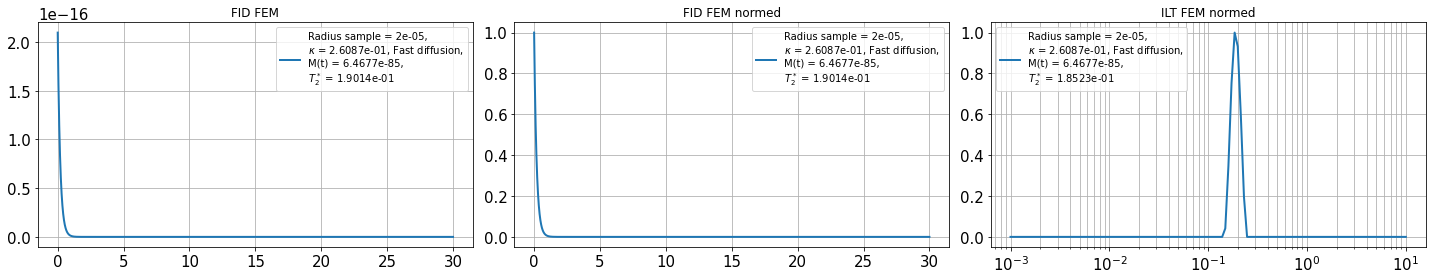

In [ ]:
plot_tripĺe_graphs(xdata1=times_, ydata1=mag_amounts_,
                   label1=f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_raw:.4e}',
                   title1=f'FID FEM', xscale1='lineal',
                   xdata2=times_, ydata2=mag_amounts_norm,
                   label2=f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_raw:.4e}',
                   title2=f'FID FEM normed', xscale2='lineal',
                   xdata3=z_value, ydata3=f_value,
                   label3=f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {max_time:.4e}',
                   title3=f'ILT FEM normed', xscale3='log',
                   figsize=(20, 4), savefig=None)

## 1D All

In [ ]:
radius= [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 175, 200, 225, 250, 275, 300]
radius_samples = np.array( [value*1.e-6 for value in radius])
for i in range(len(radius_samples)):
    print('Radius', i+1, '= %.2e' %radius_samples[i], end=', ')

surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
B0 = 0.05
t0 = 0; tf = 10; dt = 1.e-3

Radius 1 = 5.00e-06, Radius 2 = 1.00e-05, Radius 3 = 2.00e-05, Radius 4 = 3.00e-05, Radius 5 = 4.00e-05, Radius 6 = 5.00e-05, Radius 7 = 6.00e-05, Radius 8 = 7.00e-05, Radius 9 = 8.00e-05, Radius 10 = 9.00e-05, Radius 11 = 1.00e-04, Radius 12 = 1.25e-04, Radius 13 = 1.75e-04, Radius 14 = 2.00e-04, Radius 15 = 2.25e-04, Radius 16 = 2.50e-04, Radius 17 = 2.75e-04, Radius 18 = 3.00e-04, 

In [ ]:
all_times = []
all_m = []
all_mag_amounts = []
all_mag_assemble = []
all_T2fit_raw = []
all_mag_amounts_norm = []
all_T2fit_norm = []
all_bt_number = []
all_z_value = []
all_f_value = []
all_max_time = []

for radius_sample in radius_samples:
    times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=100,
                                                      mesh_stats=False, mesh_load=None,  #mesh options
                                                      T2B=T2bulk, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                      B_0=B0, Temp=303.15, fluid='water',    #initial condition ms
                                                      t_0=t0, t_f=tf, dt=dt, print_time=True, #time parameters
                                                      return_data='all',
                                                     )

    T2fit_raw = T2star_fit(times_, mag_amounts_)

    mag_amounts_norm = normalize_results(mag_amounts_)
    T2fit_norm = T2star_fit(times_, mag_amounts_norm)

    bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

    z_value, f_value = ilt(t=times_, F=mag_amounts_norm, bound=np.array([1.e-1, 1.e3]), Nz=128, alpha=0.01, normed=True)
    amp_max, max_time = maxT2_ilt(z_value, f_value)

    all_times.append(times_)
    all_m.append(m_)
    all_mag_amounts.append(mag_amounts_)
    all_mag_assemble.append(mag_assemble_)
    all_T2fit_raw.append(T2fit_raw)
    all_mag_amounts_norm.append(mag_amounts_norm)
    all_T2fit_norm.append(T2fit_norm)
    all_bt_number.append(bt_number)
    all_z_value.append(z_value)
    all_f_value.append(f_value)
    all_max_time.append(max_time)

Progress: 100%|██████| 10000/10000 [00:42<00:00, 238.09it/s]


In [ ]:
all_m_arrays = [all_m[i].vector()[:] for i in range(np.size(all_m))]

np.savez_compressed('results/all_m_arrays.npz', *all_m_arrays)

NameError: name 'all_m' is not defined

In [ ]:
load_m = np.load('results/all_m_arrays.npz')

array_names = load_m.files

m_loaded = []

for n in array_names:
    array_load = load_m[n]
    m_loaded.append(array_load)

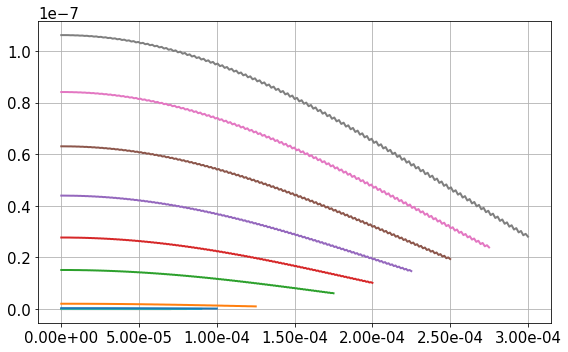

In [ ]:
import matplotlib.ticker as ticker

plt.figure(figsize=(8, 5))
for i, z in zip(range(np.shape(m_loaded)[0]), radius_samples):
    plt.plot(np.linspace(z, 0, np.size(m_loaded[1])), m_loaded[i])

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
plt.grid(True)

In [ ]:
if not os.path.exists('results'):
    os.makedirs('results')

np.savez_compressed('results/results.npz',
                    times=all_times,
                    mag_amounts=all_mag_amounts,
                    mag_assemble=all_mag_assemble,
                    T2fit_raw=all_T2fit_raw,
                    T2fit_norm=all_T2fit_norm,
                    mag_amounts_norm=all_mag_amounts_norm,
                    bt_number=all_bt_number,
                    z_value=all_z_value,
                    f_value=all_f_value,
                    max_time=all_max_time)

NameError: name 'all_times' is not defined

In [ ]:
saved_data = np.load('results/results.npz')

times_loaded = saved_data['times']
mag_amounts_loaded = saved_data['mag_amounts']
mag_assemble_loaded = saved_data['mag_assemble']
T2fit_raw_loaded = saved_data['T2fit_raw']
T2fit_norm_loaded = saved_data['T2fit_norm']
mag_amounts_norm_loaded = saved_data['mag_amounts_norm']
bt_number_loaded = saved_data['bt_number']
z_value_loaded = saved_data['z_value']
f_value_loaded = saved_data['f_value']
max_time_loaded = saved_data['max_time']

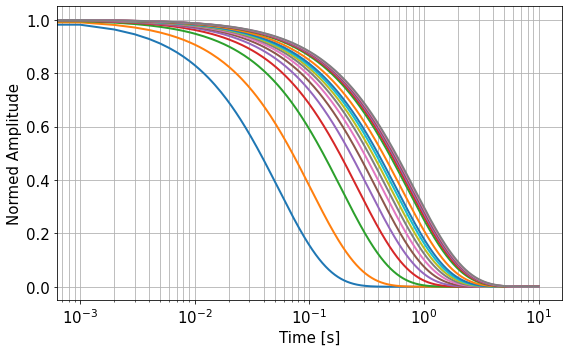

In [ ]:
plt.figure(figsize=(8, 5))
for i in range(len(times_loaded)):
    plt.plot(times_loaded[i], mag_amounts_norm_loaded[i])
    plt.grid(True, which='both')
    plt.xscale('log')
    plt.xlabel('Time [s]')
    plt.ylabel('Normed Amplitude')

In [ ]:
bt_number_array = []
for i in range(np.shape(bt_number_loaded)[0]):
    bt_number_array.append(float(bt_number_loaded[i][0]))

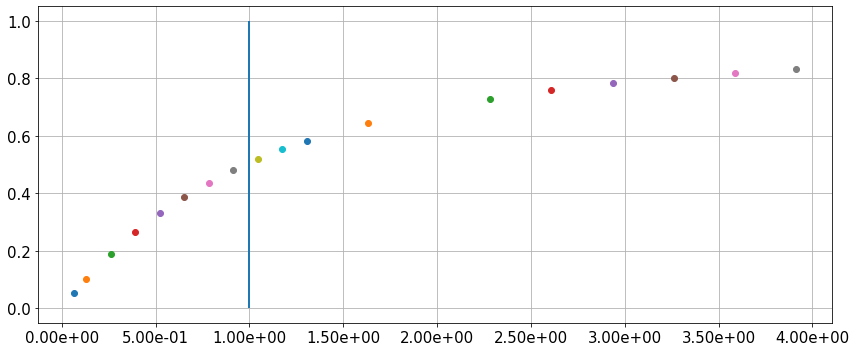

In [ ]:
plt.figure(figsize=(12, 5))
for i, j in zip(range(np.size(bt_number_array)), range(T2fit_norm_loaded.size)):
    plt.plot(bt_number_array[i], T2fit_norm_loaded[j], 'o')
    plt.grid(True, which='both')

plt.vlines(x=1, ymin=0, ymax=1)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2e'))
plt.grid(True)

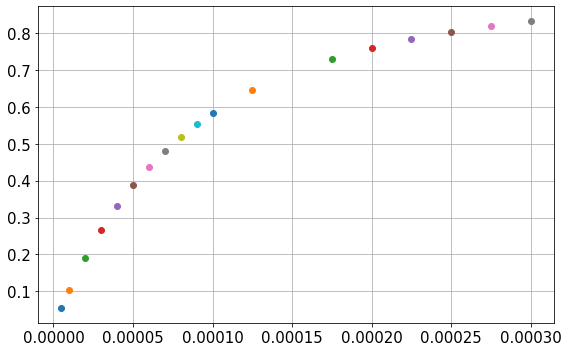

In [ ]:
plt.figure(figsize=(8, 5))
for i in range(len(radius_samples)):
    plt.plot(radius_samples[i], T2fit_norm_loaded[i], 'o')
    plt.grid(True, which='both')

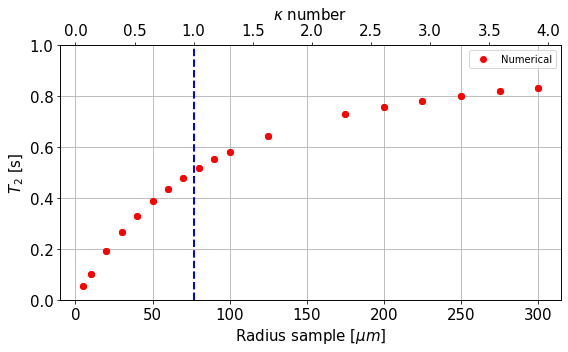

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 5))

for i in range(len(radius_samples)):
    ax1.plot(1.e6*radius_samples[i], T2fit_norm_loaded[i], 'o', color='r')
ax1.set_xlabel('Radius sample [$\mu m$]')
ax1.set_ylabel('$T_2$ [s]')
ax1.grid(True, which='both')
ax1.set_ylim(0, 1)

ax2 = ax1.twiny()

for i in range(len(bt_number_array)):
    ax2.plot(bt_number_array[i], T2fit_norm_loaded[i], 'o', color='r')
ax2.set_xlabel('$\kappa$ number')
ax2.axvline(x=1, color='b', linestyle='--')

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8, label='Numerical')]
ax1.legend(handles=legend_elements, loc='best')

plt.show()

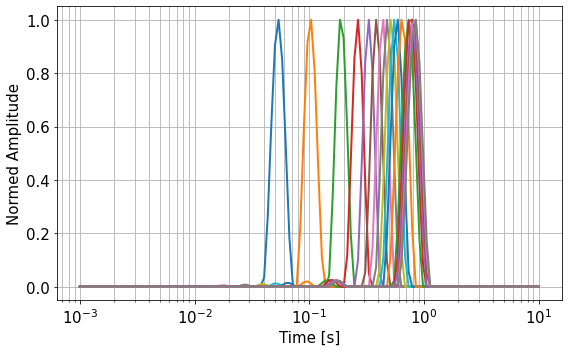

In [ ]:
plt.figure(figsize=(8, 5))
for i in range(len(z_value_loaded)):
    plt.plot(z_value_loaded[i], f_value_loaded[i])
    plt.xscale('log')
    plt.grid(True, which='both')
    plt.xlabel('Time [s]')
    plt.ylabel('Normed Amplitude')

## 1D test dt

Progress: 100%|█████| 100000/100000 [19:12<00:00, 86.78it/s]


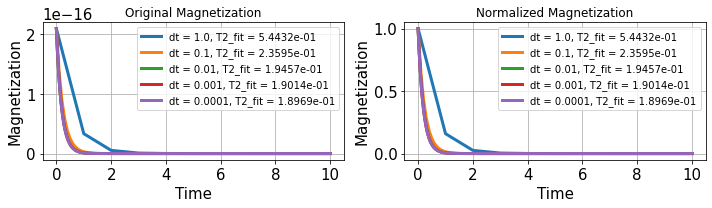

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
B0 = 0.05
t0 = 0
tf = 10

dt_values = [1.e0, 1.e-1, 1.e-2, 1.e-3, 1.e-4]

mag_amounts_list = []
T2fit_raw_list = []
mag_amounts_norm_list = []
T2fit_norm_list = []
times_list = []

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

for dt in dt_values:
    times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=500,
                                                       mesh_stats=False, mesh_load=None,  #mesh options
                                                       T2B=T2bulk, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                       B_0=B0, Temp=303.15, fluid='water',    #initial condition ms
                                                       t_0=t0, t_f=tf, dt=dt, print_time=True)  #time parameters

    T2fit_raw = T2star_fit(times_, mag_amounts_)
    mag_amounts_norm = normalize_results(mag_amounts_)
    T2fit_norm = T2star_fit(times_, mag_amounts_norm)
    bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

    axs[0].plot(times_, mag_amounts_, label=f'dt = {dt}, T2_fit = {T2fit_raw:.4e}')
    axs[1].plot(times_, mag_amounts_norm, label=f'dt = {dt}, T2_fit = {T2fit_norm:.4e}')

    mag_amounts_list.append(mag_amounts_)
    T2fit_raw_list.append(T2fit_raw)
    mag_amounts_norm_list.append(mag_amounts_norm)
    T2fit_norm_list.append(T2fit_norm)
    times_list.append(times_)

axs[0].set_title('Original Magnetization')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Magnetization')

axs[1].set_title('Normalized Magnetization')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Magnetization')

axs[0].legend()
axs[1].legend()

axs[0].grid()
axs[1].grid()

plt.tight_layout()
plt.show()

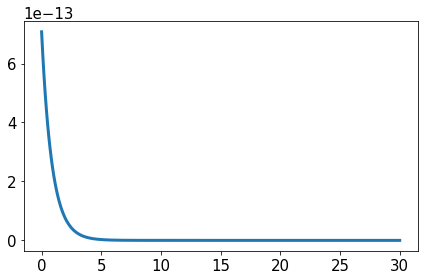

In [ ]:
for i in enumerate(time_list)plt.plot(times_list[0], mag_amounts_list[0])

In [ ]:
radius= [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 175, 200, 225, 250, 275, 300]
radius_samples = np.array( [value*1.e-6 for value in radius])
for i in range(len(radius_samples)):
    print('Radius', i+1, '= %.2e' %radius_samples[i], end=', ')

Radius 1 = 5.00e-06, Radius 2 = 1.00e-05, Radius 3 = 2.00e-05, Radius 4 = 3.00e-05, Radius 5 = 4.00e-05, Radius 6 = 5.00e-05, Radius 7 = 6.00e-05, Radius 8 = 7.00e-05, Radius 9 = 8.00e-05, Radius 10 = 9.00e-05, Radius 11 = 1.00e-04, Radius 12 = 1.25e-04, Radius 13 = 1.75e-04, Radius 14 = 2.00e-04, Radius 15 = 2.25e-04, Radius 16 = 2.50e-04, Radius 17 = 2.75e-04, Radius 18 = 3.00e-04, 

In [ ]:
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1

times_list = []
mag_amounts_list = []
mag_assemble_list = []
T2fit_raw_list = []
mag_amounts_norm_list = []
T2fit_norm_list = []
bt_number_list = []
z_value_list = []
f_value_list = []
max_time_list = []

for radius_sample in radius_samples:
    times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=300,
                                                         mesh_stats=False, mesh_load=None,  #mesh options
                                                         T2B=T2bulk, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                         B_0=0.05, Temp=303.15, fluid='water',    #initial condition ms
                                                         t_0=0, t_f=30, dt=0.01, print_time=True, #time parameters
                                                        )

    T2fit_raw = T2star_fit(times_, mag_amounts_)

    mag_amounts_norm = normalize_results(mag_amounts_)
    T2fit_norm = T2star_fit(times_, mag_amounts_norm)

    bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

    z_value, f_value= ilt(t=times_, F=mag_amounts_norm, bound=np.array([1.e-3, 1.e3]), Nz=128, alpha=0.01, normed=True)

    amp_max, max_time = maxT2_ilt(z_value, f_value)

    # Guardar los resultados para este radio de poro
    times_list.append(times_)
    mag_amounts_list.append(mag_amounts_)
    mag_assemble_list.append(mag_assemble_)
    T2fit_raw_list.append(T2fit_raw)
    mag_amounts_norm_list.append(mag_amounts_norm)
    T2fit_norm_list.append(T2fit_norm)
    bt_number_list.append(bt_number)
    z_value_list.append(z_value)
    f_value_list.append(f_value)
    max_time_list.append(max_time)

Progress:   0%|                    | 0/3000 [00:00<?, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.


Progress: 100%|████████| 3000/3000 [00:14<00:00, 202.17it/s]


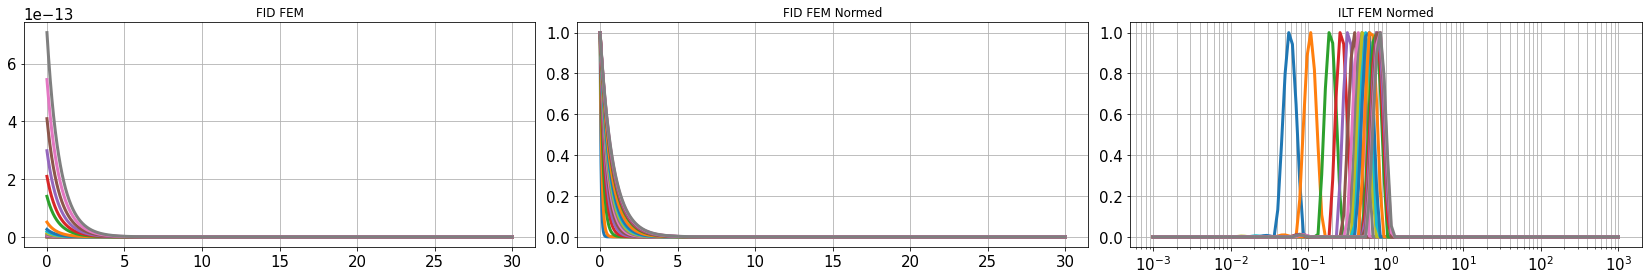

In [ ]:
# Crear la figura y los ejes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(23, 4))

for i, radius_sample in enumerate(radius_samples):
    ax1.plot(times_list[i], mag_amounts_list[i])
ax1.set_title('FID FEM')
ax1.grid(True)

for i, radius_sample in enumerate(radius_samples):
    ax2.plot(times_list[i], mag_amounts_norm_list[i])
ax2.set_title('FID FEM Normed')
ax2.grid(True)

for i, radius_sample in enumerate(radius_samples):
    ax3.plot(z_value_list[i], f_value_list[i])
ax3.set_title('ILT FEM Normed')
ax3.set_xscale('log')
ax3.grid(True, which='both')

plt.tight_layout()
plt.savefig('all_fem.png')
plt.show()


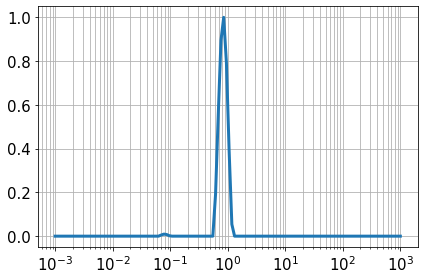

In [ ]:
plt.plot(z_value_list[0], f_value_list[17])
plt.xscale('log')
plt.grid(True, which='both')

Progress:   0%|                     | 0/300 [00:00<?, ?it/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.


Progress: 100%|████| 300000/300000 [20:39<00:00, 242.03it/s]


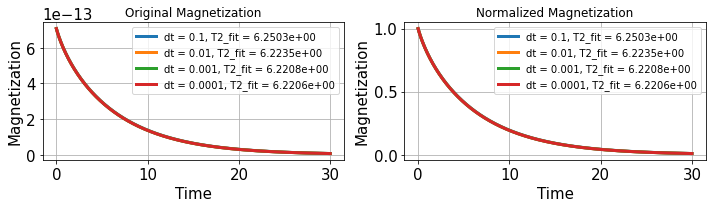

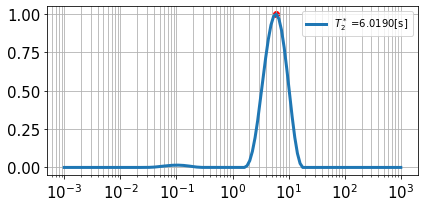

In [ ]:
z_, f_= ilt(t=times_list[0], F=mag_amounts_norm_list[0], bound=np.array([1.e-3, 1.e3]), Nz=128, alpha=1, normed=True)
imax_f_ = np.argmax(f_)
max_f_ = f_[imax_f_]
time_z_ = z_[imax_f_]
plt.figure(figsize=(6, 3))
plt.plot(z_, f_, label=f'$T_2^*$ ={time_z_:.4f}[s]')
plt.xscale('log')
plt.grid(which='both')
plt.scatter(time_z_, max_f_, color='red')
plt.legend()

## 3D test

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

times_, m_, mag_amounts_, mag_assemble_ = NMR_FEM(radius=radius_sample, aspect_ratio = 1, dimension=3,
                                                  mesh_res=20, mesh_stats = True, mesh_load=None,  #mesh options
                                                  T2B=0.05, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                  B_0=0.05, Temp=303.15, fluid='water',    #initial condition ms
                                                  t_0=0, t_f=1, dt=0.001, print_time=True, #time parameters
                                                 )

T2fit_raw = T2star_fit(times_, mag_amounts_)

mag_amounts_norm = normalize_results(mag_amounts_)
T2fit_norm = T2star_fit(times_, mag_amounts_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

plot_dual_graphs(times_, mag_amounts_, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_raw[0]:.4e}', f'FID FEM',
                 times_, mag_amounts_norm, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_:.4e},\n$T_2^*$ = {T2fit_norm[0]:.4e}', f'FID FEM normed',
                 figsize=(10, 3))

# Conventional

## Code

In [ ]:
#TO-DO: añadir opciones para estimar T2 bulk
def NMR_Conventional(radius=1, aspect_ratio = 1, #SV_ratio
                     T2B=1., diffusion=2.3e-9, rho=30e-6, #T2_star
                     B_0=0.05, Temp=303.15, fluid='water', #mag_sat
                     t_0=0, t_f=1, dt=1.e-3, #time must be an array
                    ):
    nt = int((t_f-t_0)/dt) + 1
    t = np.linspace(t_0, t_f, nt)

    assert fluid in ['water', 'oil', 'gas']

    # Calculating magnetic saturation
    def mag_sat(B_0, Temp, fluid):
        assert fluid in ['water', 'oil', 'gas']
        avogadro_number = 6.0220e23
        h_planck = 6.626e-34
        k_boltzmann = 1.380e-23
        gamma = 267.5e6

        if fluid == 'water':
            number_hydrogen = 2.
            fluid_mol_weight = 18.0153e-3
            fluid_density = 9.97e2
        elif fluid == 'oil':
            number_hydrogen = 12.
            fluid_mol_weight = 72.151e-3
            fluid_density = 6.26e2
        elif fluid == 'gas':
            number_hydrogen = 4.
            fluid_mol_weight = 16.04e-3
            fluid_density = 6.56e-1

        proton_density = (number_hydrogen * avogadro_number * fluid_density) / fluid_mol_weight
        m_s = (proton_density * B_0 * (gamma**2) * (h_planck**2)) / (4. * k_boltzmann * Temp)
        return m_s

    # Calculating surface area and volume ratio
    def SV_ratio(radius, aspect_ratio):

        if aspect_ratio == 1:
            S = 4. * np.pi * np.power(radius, 2)
            V = 4. * np.pi * np.power(radius, 3) / 3.
        else:
            a = radius
            b = radius*aspect_ratio
            c = radius*aspect_ratio
            S = 4. * np.pi * (((a * b) ** 1.6 + (a * c) ** 1.6 + (b * c) ** 1.6) / 3.) ** (1. / 1.6)
            V = 4. * np.pi * a * b * c / 3.

        SVratio = S / V
        return S, V, SVratio

    S_value_geom, V_value_geom, SV_ratio_value_geom = SV_ratio(radius, aspect_ratio)

    # Calculating Amplitude
    def A(ms, V):
        Amplitude = ms * V
        return Amplitude

    # Calculating conventional T2star
    def T2star_conventional(T2B, rho, SVratio):
        if T2B <= 0:
            T_2star = 1. / (rho * SVratio)
        else:
            T_2star = 1. / ((1. / T2B) + rho * SVratio)
        return T_2star

    # Calculating NMR signal
    def nmr_signal(t, radius, aspect_ratio, T2B, rho, B_0, Temp, fluid):
        m_sat = mag_sat(B_0, Temp, fluid)
        S_value, V_value, SV_ratio_value = SV_ratio(radius, aspect_ratio)
        Amplitude_value = A(m_sat, V_value)
        T2s = T2star_conventional(T2B, rho, SV_ratio_value)
        return Amplitude_value * np.exp(-t / T2s)

    # NMR signal
    mag_amounts = nmr_signal(t, radius, aspect_ratio, T2B, rho, B_0, Temp, fluid)

    # NMR integral
    mag_assemble = quad(nmr_signal, 0, V_value_geom, args=(radius, aspect_ratio, T2B, rho, B_0, Temp, fluid))[0]

    return mag_amounts, mag_assemble

## Sphere test

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
t0 = 0; tf = 30; dt=1.e-3

nt = int((tf-t0)/dt)+1
time_array = np.linspace(t0, tf, nt)

Surface_sample, Volume_sample, SurfVol_ratio = SV_ratio_analytical(radius_sample, aspect_ratio=1)

print(f'Analytical volume: {Volume_sample:.4e},\nAnalytical surface: {Surface_sample:.4e}, \nAnalytical Surface to Volume ratio: {SurfVol_ratio:.4e}')
print(f'Analytical T2*: {T2star_conventional(T2B=T2bulk, rho=surface_relaxivity, SVratio= SurfVol_ratio):.4e}')

mag_amounts_c, mag_assemble_c = NMR_Conventional(radius=radius_sample, aspect_ratio=1,
                                 T2B=T2bulk, rho = surface_relaxivity,
                                 B_0=0.05, Temp=303.15, fluid='water',
                                 t_0=t0, t_f=tf, dt=dt)

T2fit_raw_c = T2star_fit(time_array, mag_amounts_c)

mag_amounts_c_norm = normalize_results(mag_amounts_c)
T2fit_norm_c = T2star_fit(time_array, mag_amounts_c_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

z_value_c, f_value_c= ilt(t=time_array, F=mag_amounts_c_norm, bound=np.array([1.e-1, 1.e3]), Nz=128, alpha=0.01, normed=False)
amp_max_c, max_time_c = maxT2_ilt(z_value_c, f_value_c)

Analytical volume: 3.3510e-14,
Analytical surface: 5.0265e-09, 
Analytical Surface to Volume ratio: 1.5000e+05
Analytical T2*: 1.8182e-01


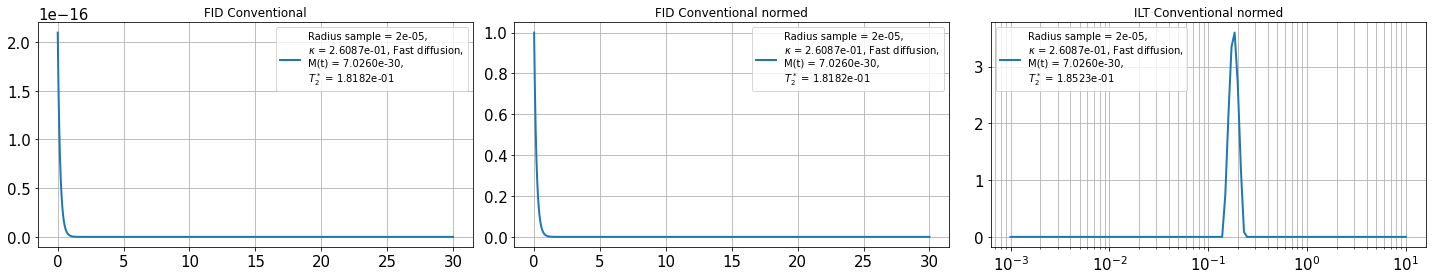

In [ ]:
plot_tripĺe_graphs(xdata1=time_array, ydata1=mag_amounts_c,
                   label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_raw_c:.4e}',
                   title1 = f'FID Conventional', xscale1='lineal',
                   xdata2=time_array, ydata2=mag_amounts_c_norm,
                   label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_norm_c:.4e}',
                   title2 =f'FID Conventional normed', xscale2='lineal',
                   xdata3=z_value_c,  ydata3=f_value_c,
                   label3 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {max_time_c:.4e}',
                   title3 =f'ILT Conventional normed', xscale3='log',
                   figsize=(20, 4), savefig=None)

In [ ]:
radius= [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 125, 175, 200, 225, 250, 275, 300]
radius_samples = np.array( [value*1.e-6 for value in radius])
for i in range(len(radius_samples)):
    print('Radius', i+1, '= %.2e' %radius_samples[i], end=', ')

surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
B0 = 0.05
t0 = 0; tf = 10; dt = 1.e-3

Radius 1 = 5.00e-06, Radius 2 = 1.00e-05, Radius 3 = 2.00e-05, Radius 4 = 3.00e-05, Radius 5 = 4.00e-05, Radius 6 = 5.00e-05, Radius 7 = 6.00e-05, Radius 8 = 7.00e-05, Radius 9 = 8.00e-05, Radius 10 = 9.00e-05, Radius 11 = 1.00e-04, Radius 12 = 1.25e-04, Radius 13 = 1.75e-04, Radius 14 = 2.00e-04, Radius 15 = 2.25e-04, Radius 16 = 2.50e-04, Radius 17 = 2.75e-04, Radius 18 = 3.00e-04, 

## Ellipsoid test

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9

Surface_sample, Volume_sample, SurfVol_ratio = SV_ratio_analytical(radius_sample, aspect_ratio=0.5)

print(f'Analytical volume: {Volume_sample:.4e},\nAnalytical surface: {Surface_sample:.4e}, \nAnalytical Surface to Volume ratio: {SurfVol_ratio:.4e}')
print(f'Analytical T2*: {T2star_conventional(T2B=0.05, rho=surface_relaxivity, SVratio= SurfVol_ratio):.4e}')

time_array = np.linspace(0, 1, 10000)

mag_amounts_c, mag_assemble_c = NMR_Conventional(radius=radius_sample, aspect_ratio=0.5,
                                                 T2B=0.05, rho = surface_relaxivity,
                                                 B_0=0.05, Temp=303.15, fluid='water',
                                                 t=time_array,)

T2fit_raw_c = T2star_fit(time_array, mag_amounts_c)

mag_amounts_c_norm = normalize_results(mag_amounts_c)
T2fit_norm_c = T2star_fit(time_array, mag_amounts_c_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

plot_dual_graphs(xdata1=time_array, ydata1=mag_amounts_c,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_raw_c[0]:.4e}',
                 title1 = f'FID Conventional',
                 xdata2=time_array, ydata2=mag_amounts_c_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_norm_c[0]:.4e}',
                 title2 =f'FID Conventional normed',
                 figsize=(10, 3))

# Analytical

## Code

In [ ]:
def M_sphere(radius, rho, diffusion, T2B, n, rleft, rright, tol, t0, tf, dt,):

    def f(x):
        return float(1-(x*mpmath.cot(x)) - ((radius*rho)/diffusion))

    # Calculating magnetic saturation
    def mag_sat(B_0=0.05, Temp=303.15, fluid='water'):
        assert fluid in ['water', 'oil', 'gas']
        avogadro_number = 6.0220e23
        h_planck = 6.626e-34
        k_boltzmann = 1.380e-23
        gamma = 267.5e6

        if fluid == 'water':
            number_hydrogen = 2.
            fluid_mol_weight = 18.0153e-3
            fluid_density = 9.97e2
        elif fluid == 'oil':
            number_hydrogen = 12.
            fluid_mol_weight = 72.151e-3
            fluid_density = 6.26e2
        elif fluid == 'gas':
            number_hydrogen = 4.
            fluid_mol_weight = 16.04e-3
            fluid_density = 6.56e-1

        proton_density = (number_hydrogen * avogadro_number * fluid_density) / fluid_mol_weight
        m_s = (proton_density * B_0 * (gamma**2) * (h_planck**2)) / (4. * k_boltzmann * Temp)
        return m_s

    eigbetam = []
    root = []
    Tn_values = []

    for i in range(1, n + 1):
        a = (i - 1) * rleft + tol
        b = i * rright - tol
        r = opt.brentq(f, float(a), float(b))
        rt= np.power(r, 2)
        eigbetam.append(r)
        root.append(rt)
        Tn = np.power(radius, 2) / (diffusion * np.power(r, 2))
        Tn_values.append(Tn)

    eigbetam = np.unique(eigbetam)
    lengthv = len(eigbetam)

    volume_sphere = 4/3 * np.pi * radius**3

    def M(t):
        s = 0.0
        for i in range(0, lengthv):
            r = eigbetam[i]
            a = np.sin(r) - r * np.cos(r)
            b = np.power(r,3) * (2 * r - np.sin(2 * r))
            if T2B <= 0:
                bulk_term = 0
            else:
                bulk_term = 1/T2B
            m0 = mag_sat(B_0=0.05, Temp=303.15, fluid='water') *volume_sphere
            s +=  m0 * (12 *np.power(a,2)/ b * np.exp(-t*((1/Tn_values[0]) + bulk_term)))
        return s

    #print('Analytical error = ', 1-M(0))

    t = 0.0
    NT = int((tf - t0) / dt)
    times = np.zeros(NT + 1)
    MM = np.zeros(NT + 1)

    for i in range(0, NT + 1):
        t = i * dt
        times[i] = t
        MM[i] = M(t)

    # NMR integral
    mag_assemble = quad(M, 0, volume_sphere)[0]

    return times, MM, eigbetam, root, Tn_values, mag_assemble

## Sphere test

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
t0 = 0; tf=30; dt=1.e-3

times_a, MM_, eigbetam_, root_, Tn_values_, mag_assemble_a = M_sphere(radius=radius_sample,
         rho=surface_relaxivity, diffusion=diffusion_water, T2B=T2bulk,
         n=50, rleft=np.pi, rright=np.pi, tol=1.e-5,
         t0=t0, tf=tf, dt=dt,)

T2fit_raw_a = T2star_fit(times_a, MM_)

mag_amounts_a_norm = normalize_results(MM_)
T2fit_norm_a = T2star_fit(times_a, mag_amounts_a_norm)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=True)

z_value_a, f_value_a= ilt(t=times_a, F=mag_amounts_a_norm, bound=np.array([1.e-1, 1.e3]), Nz=128, alpha=0.01, normed=True)

amp_max_a, max_time_a = maxT2_ilt(z_value_a, f_value_a)

Pore 2.00e-05 [m], Fast diffusion: 0.2609


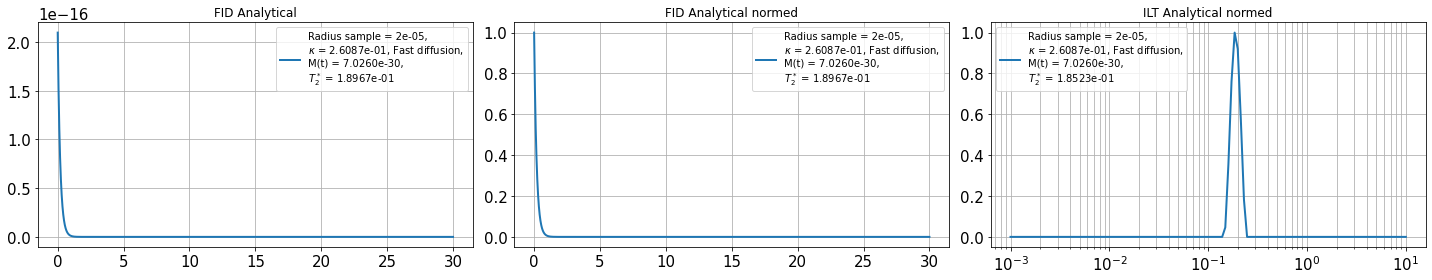

In [ ]:
plot_tripĺe_graphs(xdata1=times_a, ydata1=MM_,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_a:.4e},\n$T_2^*$ = {T2fit_raw_a:.4e}',
                 title1 = f'FID Analytical', xscale1='lineal',
                 xdata2=times_a, ydata2=mag_amounts_a_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_a:.4e},\n$T_2^*$ = {T2fit_norm_a:.4e}',
                 title2 =f'FID Analytical normed', xscale2='lineal',
                 xdata3=z_value_a, ydata3=f_value_a,
                 label3 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_a:.4e},\n$T_2^*$ = {max_time_a:.4e}',
                 title3 =f'ILT Analytical normed', xscale3='log',
                 figsize=(20, 4), savefig=None)

# Comparative cases

## Numerical vs Analytical

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2Bulk = 0.05
B0 = 0.05
Temperature = 303.15
fluid_sample = 'water'
t0 = 0
tf = 1
dt = 0.001

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

#Numerical case
times_num, m_num, mag_amounts_num, mag_assemble_num = NMR_FEM(radius=radius_sample, aspect_ratio=1, dimension=1, mesh_res=100,
                                                         mesh_stats = True, mesh_load=None,  #mesh options
                                                         T2B=T2Bulk, diffusion=diffusion_water, rho=surface_relaxivity,  #model parameters
                                                         B_0=B0, Temp=Temperature, fluid=fluid_sample,    #initial condition ms
                                                         t_0=t0, t_f=tf, dt=dt, print_time=True, #time parameters
                                                        )

T2fit_raw_num = T2star_fit(times_num, mag_amounts_num)

mag_amounts_norm_num = normalize_results(mag_amounts_num)
T2fit_norm_num = T2star_fit(times_num, mag_amounts_norm_num)

plot_dual_graphs(times_num, mag_amounts_num, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_raw_num[0]:.4e}', f'FID FEM',
                 times_num, mag_amounts_norm_num, f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_norm_num[0]:.4e}', f'FID FEM normed',
                 figsize=(10, 3))

print('--------------------------------------------')

#Analytical case
times_an, MM_an, eigbetam_an, root_an, Tn_values_an, mag_assemble_an = M_sphere(radius=radius_sample,
         rho=surface_relaxivity, diffusion=diffusion_water, T2B=T2Bulk,
         n=1000, rleft=np.pi, rright=np.pi, tol=1.e-6,
         t0=t0, tf=tf, dt=dt,)

T2fit_raw_an = T2star_fit(times_an, MM_an)

mag_amounts_norm_an = normalize_results(MM_an)
T2fit_norm_an = T2star_fit(times_an, mag_amounts_norm_an)

plot_dual_graphs(xdata1=times_an, ydata1=MM_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'FID Analytical',
                 xdata2=times_an, ydata2=mag_amounts_norm_an,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title2 =f'FID Analytical normed',
                 figsize=(10, 3))

In [ ]:
absolute_error_num_vs_an, relative_error_num_vs_an = error_estimation(MM_an, mag_amounts_num)
absolute_error_num_vs_an_norm, relative_error_num_vs_an_norm = error_estimation(mag_amounts_norm_an, mag_amounts_norm_num)

In [ ]:
plot_dual_graphs(xdata1=times_an, ydata1=MM_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'FID Analytical',
                 xdata2=times_num, ydata2=mag_amounts_num,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_raw_num[0]:.4e}',
                 title2 =f'FID Numerical',
                 figsize=(10, 3))

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(times_an, MM_an,)
plt.plot(times_num, mag_amounts_num,)
plt.grid()

In [ ]:
plot_dual_graphs(xdata1=np.arange(absolute_error_num_vs_an.size), ydata1=absolute_error_num_vs_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'Absolute error Analytical vs Numerical',
                 xdata2=np.arange(relative_error_num_vs_an.size), ydata2=relative_error_num_vs_an,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_raw_num[0]:.4e}',
                 title2 =f'Relative error Analytical vs Numerical',
                 figsize=(10, 3))

In [ ]:
plot_dual_graphs(xdata1=times_an, ydata1=mag_amounts_norm_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title1 = f'FID Analytical normed',
                 xdata2=times_num, ydata2=mag_amounts_norm_num,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_norm_num[0]:.4e}',
                 title2 =f'FID Numerical normed',
                 figsize=(10, 3))

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(times_an, mag_amounts_norm_an)
plt.plot(times_num, mag_amounts_norm_num)
plt.grid()

In [ ]:
plot_dual_graphs(xdata1=np.arange(absolute_error_num_vs_an_norm.size), ydata1=absolute_error_num_vs_an_norm,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title1 = f'Absolute error Analytical vs Numerical',
                 xdata2=np.arange(relative_error_num_vs_an_norm.size), ydata2=relative_error_num_vs_an_norm,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_num:.4e},\n$T_2^*$ = {T2fit_norm_num[0]:.4e}',
                 title2 =f'Relative error Analytical vs Numerical',
                 figsize=(10, 3))

## Conventional vs Analytical

In [ ]:
radius_sample = 20.e-6
surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2Bulk = 0.05
B0 = 0.05
Temperature = 303.15
fluid_sample = 'water'
t0 = 0
tf = 1
dt = 0.001

nt = int((tf-t0)/dt) + 1
time_array = np.linspace(t0, tf, nt)

bt_number = BrownsteinTarr_number(radius_sample, surface_relaxivity, diffusion_water, text=False)

#Conventional case
Surface_sample, Volume_sample, SurfVol_ratio = SV_ratio_analytical(radius_sample, aspect_ratio=1)

print(f'Analytical volume: {Volume_sample:.4e},\nAnalytical surface: {Surface_sample:.4e}, \nAnalytical Surface to Volume ratio: {SurfVol_ratio:.4e}')
print(f'Analytical T2*: {T2star_conventional(T2B=T2Bulk, rho=surface_relaxivity, SVratio= SurfVol_ratio):.4e}')

mag_amounts_c, mag_assemble_c = NMR_Conventional(radius=radius_sample, aspect_ratio=1,
                                 T2B=T2Bulk, rho = surface_relaxivity,
                                 B_0=B0, Temp=Temperature, fluid=fluid_sample,
                                 t=time_array,)

T2fit_raw_c = T2star_fit(time_array, mag_amounts_c)

mag_amounts_norm_c = normalize_results(mag_amounts_c)
T2fit_norm_c = T2star_fit(time_array, mag_amounts_norm_c)

plot_dual_graphs(xdata1=time_array, ydata1=mag_amounts_c,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_raw_c[0]:.4e}',
                 title1 = f'FID Conventional',
                 xdata2=time_array, ydata2=mag_amounts_norm_c,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_c:.4e},\n$T_2^*$ = {T2fit_norm_c[0]:.4e}',
                 title2 =f'FID Conventional normed',
                 figsize=(10, 3))

print('--------------------------------------------')

#Analytical case
times_an, MM_an, eigbetam_an, root_an, Tn_values_an, mag_assemble_an = M_sphere(radius=radius_sample,
         rho=surface_relaxivity, diffusion=diffusion_water, T2B=T2Bulk,
         n=1000, rleft=np.pi, rright=np.pi, tol=1.e-6,
         t0=t0, tf=tf, dt=dt,)

T2fit_raw_an = T2star_fit(times_an, MM_an)

mag_amounts_norm_an = normalize_results(MM_an)
T2fit_norm_an = T2star_fit(times_an, mag_amounts_norm_an)

plot_dual_graphs(xdata1=times_an, ydata1=MM_an,
                 label1 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_raw_an[0]:.4e}',
                 title1 = f'FID Analytical',
                 xdata2=times_an, ydata2=mag_amounts_norm_an,
                 label2 = f'Radius sample = {radius_sample},\n$\kappa$ = {bt_number[0]:.4e}, {bt_number[1]},\nM(t) = {mag_assemble_an:.4e},\n$T_2^*$ = {T2fit_norm_an[0]:.4e}',
                 title2 =f'FID Analytical normed',
                 figsize=(10, 3))

In [ ]:
absolute_error_c_vs_an, relative_error_c_vs_an = error_estimation(MM_an, mag_amounts_c)
absolute_error_c_vs_an_norm, relative_error_c_vs_an_norm = error_estimation(mag_amounts_norm_an, mag_amounts_norm_c)

# Pore Size Distributions

## Normal distribution

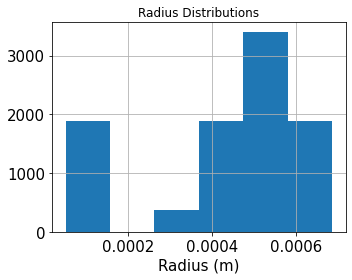

In [ ]:
def W(sample, distribution):
    min_radius = sample.min()
    max_radius = sample.max()
    radius_values = np.linspace(min_radius, max_radius, num=np.size(sample))
    W_radius = distribution.pdf(x=radius_values)
    return radius_values, W_radius

#Pore size distribution
mean1 = 500.e-6
std1 = 100.e-6
mean2 = 100.e-6
std2 = 50.e-6

radius_distribution1 = norm(loc=mean1, scale=std1)
radius_distribution2 = norm(loc=mean2, scale=std2)

radius_sample1 = np.abs(radius_distribution1.rvs(size=20))
radius_sample2 = np.abs(radius_distribution2.rvs(size=5))

#radius_sample = radius_sample1
dist_radius_sample = np.concatenate([radius_sample1, radius_sample2])

#rad_values, probabilities_radius = W(radius_sample, radius_distribution1)

plt.figure(figsize=(5, 4))
#plt.plot(rad_values, probabilities_radius)
plt.hist(dist_radius_sample, bins='sturges', density=True)
plt.title('Radius Distributions')
plt.xlabel('Radius (m)')
plt.grid(True, 'both')

#plt.savefig('rad_dist_2.png')

## Test 1, mag integral

In [ ]:
%%time

surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
t0=0; tf=5; dt= 1.e-3

signal_for_radius = np.zeros_like(radius_sample)

for i, r in enumerate(radius_sample):
    signal_for_radius[i] += NMR_FEM(radius=r, dimension=1, mesh_res=100,
            T2B=T2bulk, diffusion=diffusion_water, rho=surface_relaxivity,
            t_0=t0, t_f=tf, dt=dt,print_time=False, return_data='mag_assemble')


KeyboardInterrupt: 

In [ ]:
mt_signal_total = np.sort(signal_for_radius, axis=-1)[::-1]
mt_signal_normed = normalize_results(mt_signal_total)
times_signal = np.linspace(t0, tf, np.size(mt_signal_total))
T2_fit_signal = T2star_fit(times_signal, mt_signal_normed)

In [ ]:
from scipy.interpolate import interp1d

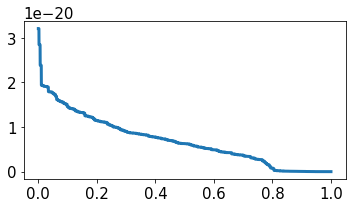

In [ ]:
f = interp1d(times_signal, mt_signal_total, kind='nearest')
time_smooth = np.linspace(times_signal.min(), times_signal.max(), 10000)

mt_smooth = f(time_smooth)

plt.figure(figsize=(5, 3))
plt.plot(time_smooth, mt_smooth)

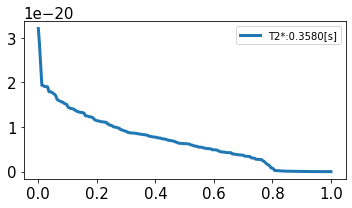

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(times_signal,mt_signal_total, label=f'T2*:{T2_fit_signal:.4f}[s]')
plt.legend()

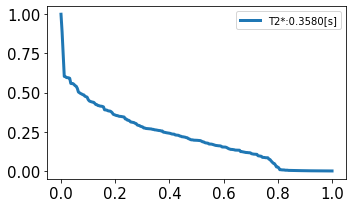

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(times_signal,mt_signal_normed, label=f'T2*:{T2_fit_signal:.4f}[s]')
plt.legend()

In [ ]:
z_, f_ = ilt(t=times_signal, F=mt_signal_normed, bound=np.array([1.e-4, 1.e4]), Nz=128, alpha=10, normed=True)
amp_, timex = maxT2_ilt(z_, f_)

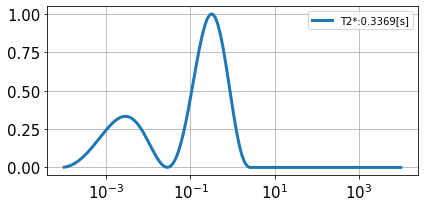

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(z_, f_,  label=f'T2*:{timex:.4f}[s]')
plt.legend()
plt.xscale('log')
plt.grid(True, which='both')

## Test 2

In [ ]:
%%time

surface_relaxivity = 30.e-6
diffusion_water = 2.3e-9
T2bulk = 1
B0 = 0.05
t0 = 0; tf = 10; dt = 1.e-3

sequences = []

for i, r in enumerate(dist_radius_sample):
    sequence_for_radius = NMR_FEM(radius=r, dimension=1, mesh_res=100,
                                   T2B=T2bulk, diffusion=diffusion_water,
                                   rho=surface_relaxivity, t_0=t0, t_f=tf,
                                   dt=dt, print_time=True, return_data='mag_amounts')

    sequences.append(sequence_for_radius)

Progress: 100%|██████| 10000/10000 [00:45<00:00, 220.36it/s]

CPU times: user 17min 37s, sys: 30.9 s, total: 18min 8s
Wall time: 18min 20s


In [ ]:
for i in range(len(dist_radius_sample)):
    BrownsteinTarr_number(dist_radius_sample[i], surface_relaxivity, diffusion_water, text=True)


Pore 4.13e-04 [m], Intermediate diffusion: 5.3919
Pore 6.78e-04 [m], Intermediate diffusion: 8.8445
Pore 4.65e-04 [m], Intermediate diffusion: 6.0709
Pore 4.49e-04 [m], Intermediate diffusion: 5.8504
Pore 5.43e-04 [m], Intermediate diffusion: 7.0793
Pore 6.86e-04 [m], Intermediate diffusion: 8.9521
Pore 5.71e-04 [m], Intermediate diffusion: 7.4454
Pore 4.14e-04 [m], Intermediate diffusion: 5.4059
Pore 5.03e-04 [m], Intermediate diffusion: 6.5599
Pore 5.64e-04 [m], Intermediate diffusion: 7.3605
Pore 4.80e-04 [m], Intermediate diffusion: 6.2544
Pore 6.64e-04 [m], Intermediate diffusion: 8.6598
Pore 3.47e-04 [m], Intermediate diffusion: 4.5322
Pore 5.62e-04 [m], Intermediate diffusion: 7.3279
Pore 4.27e-04 [m], Intermediate diffusion: 5.5640
Pore 6.32e-04 [m], Intermediate diffusion: 8.2411
Pore 5.44e-04 [m], Intermediate diffusion: 7.0992
Pore 4.74e-04 [m], Intermediate diffusion: 6.1873
Pore 6.60e-04 [m], Intermediate diffusion: 8.6080
Pore 4.95e-04 [m], Intermediate diffusion: 6.4552


In [ ]:
time_array_sequences = np.linspace(t0, tf, int((tf-t0)/dt)+1)
print(time_array_sequences.size)

10001


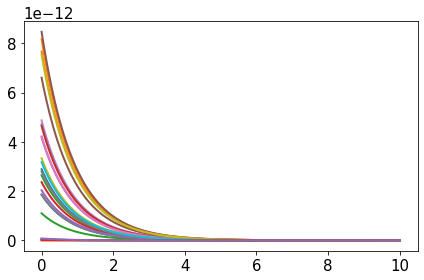

In [ ]:
for i in range(np.shape(sequences)[0]):
    plt.plot(time_array_sequences, sequences[i])

In [ ]:
total_signal_over_time1 = np.sum(sequences,axis=1)
print(total_signal_over_time1)

[1.61706644e-09 7.53084611e-09 2.34410433e-09 2.08813135e-09
 3.78216231e-09 7.81681866e-09 4.42246369e-09 1.63029771e-09
 2.98447077e-09 4.26802534e-09 2.57229095e-09 7.05614875e-09
 9.35532851e-10 4.20966825e-09 1.78456670e-09 6.05505948e-09
 3.81526401e-09 2.48724474e-09 6.92677724e-09 2.83860314e-09
 3.61121469e-11 2.65611869e-12 2.97759148e-11 1.29975198e-12
 5.39774144e-11]


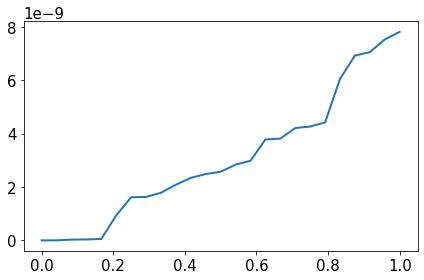

In [ ]:
plt.plot(np.linspace(0, 1, np.size(total_signal_over_time1)), np.sort(total_signal_over_time1))

In [ ]:
total_signal_over_time = np.sum(sequences,axis=0)
print(total_signal_over_time)

[8.53508423e-11 8.52521021e-11 8.51536161e-11 ... 1.88115374e-15
 1.87916523e-15 1.87717882e-15]


In [ ]:
total_signal_over_time = np.trapz(sequences,axis=0)
print(total_signal_over_time)

[8.43854397e-11 8.42878854e-11 8.41905817e-11 ... 1.86671997e-15
 1.86474723e-15 1.86277658e-15]


In [ ]:
T2_fit_signal1 = T2star_fit(time_array_sequences, total_signal_over_time)
print(T2_fit_signal1)

0.9083218883385226


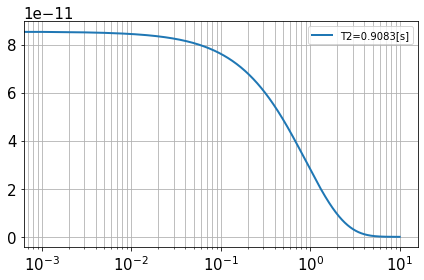

In [ ]:
plt.plot(time_array_sequences, total_signal_over_time, label=f'T2={T2_fit_signal1:.4f}[s]')
plt.xscale('log')
plt.legend()
plt.grid(True, which='both')

In [ ]:
total_signal_over_time_norm = normalize_results(total_signal_over_time)
print(total_signal_over_time_norm)

[1.00000000e+00 9.98843126e-01 9.97689230e-01 ... 2.20402482e-05
 2.20169501e-05 2.19936766e-05]


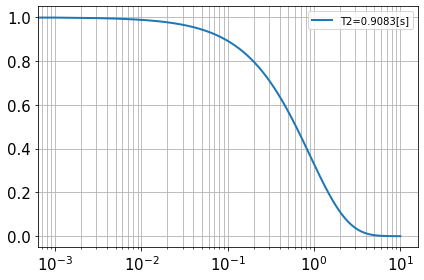

In [ ]:
plt.plot(time_array_sequences, total_signal_over_time_norm, label=f'T2={T2_fit_signal1:.4f}[s]')
plt.xscale('log')
plt.legend()
plt.grid(True, which='both')

In [ ]:
z_sec, f_sec = ilt(t=time_array_sequences, F=total_signal_over_time_norm, bound=np.array([1.e-3, 1.e3]), Nz=300, alpha=1, normed=True)
amp_sec, timexsec = maxT2_ilt(z_sec, f_sec)

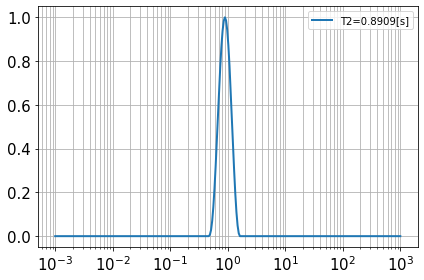

In [ ]:
plt.plot(z_sec, f_sec, label=f'T2={timexsec:.4f}[s]')
plt.legend()
plt.xscale('log')
plt.grid(True, which='both')

In [ ]:
total_signal_over_time = np.sum(sequences, axis=0)


time_arr = np.linspace(t0, tf, np.size(total_signal_over_time))
print(time_arr.size)

T2_fit_signal1 = T2star_fit(time_arr, total_signal_over_time)

print(total_signal_over_time.size)


1001
1001


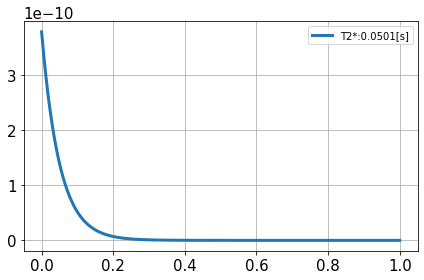

In [ ]:
plt.plot(time_arr, total_signal_over_time, label=f'T2*:{T2_fit_signal1:.4f}[s]')
#plt.plot(times_signal,mt_signal_normed, label=f'T2*:{T2_fit_signal:.4f}[s]')
plt.legend()
#plt.savefig('total_signal_1.png')
plt.grid()

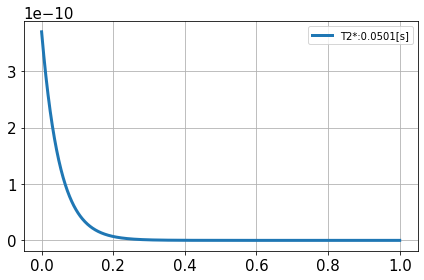

In [ ]:
plt.plot(time_arr, total_signal_over_time, label=f'T2*:{T2_fit_signal1:.4f}[s]')
#plt.plot(times_signal,mt_signal_normed, label=f'T2*:{T2_fit_signal:.4f}[s]')
plt.legend()
#plt.savefig('total_signal_1.png')
plt.grid()

In [ ]:
z_sec, f_sec = ilt(t=time_arr, F=normalize_results(total_signal_over_time), bound=np.array([1.e-3, 1.e3]), Nz=128, alpha=10, normed=True)
amp_sec, timexsec = maxT2_ilt(z_sec, f_sec)

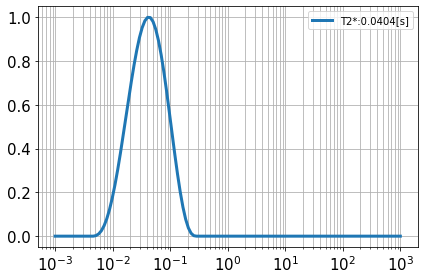

In [ ]:
plt.plot(z_sec, f_sec, label=f'T2*:{timexsec:.4f}[s]')
plt.xscale('log')
plt.legend()
plt.grid(True, which='both')
#plt.savefig('ilt_total_signal.png')

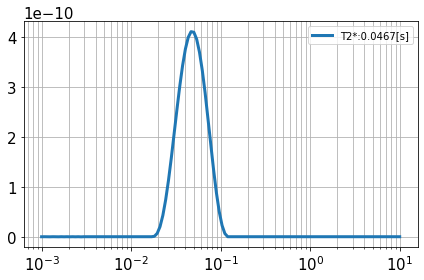

In [ ]:
plt.plot(z_sec, f_sec, label=f'T2*:{timexsec:.4f}[s]')
plt.xscale('log')
plt.legend()
plt.grid(True, which='both')
#plt.savefig('ilt_total_signal.png')

## Test 3

In [ ]:
def NMR_FEM_multi_r_time(radii_list, *args, **kwargs):
    signals_over_time = []
    for radius in radii_list:
        signals = []
        for t in tqdm(np.linspace(kwargs['t_0'], kwargs['t_f'], int((kwargs['t_f'] - kwargs['t_0']) / kwargs['dt']) + 1), desc='Progress'):
            kwargs['radius'] = radius
            kwargs['t_f'] = t
            signal_for_radius = NMR_FEM(*args, **kwargs)
            signals.append(signal_for_radius)
        signals_over_time.append(signals)

    total_signal_over_time = np.sum(signals_over_time, axis=0)
    return total_signal_over_time

In [ ]:
radii_list = radius_sample
total_signal_over_time = NMR_FEM_multi_r_time(radii_list, aspect_ratio=1, dimension=1, mesh_res=100,
                                              mesh_stats=False, mesh_load=None,
                                              T2B=0.05, diffusion=2.3e-9, rho=2.3e-9,
                                              B_0=0.05, Temp=303.15, fluid='water',
                                              t_0=0, t_f=1, dt=0.001, print_time=False)

In [ ]:
# Obtener los tiempos
t_0=0; t_f=1; dt= 0.01
times = np.linspace(t_0, t_f, int((t_f - t_0) / dt) + 1)

normed_signal = normalize_results(total_signal_over_time)
print(T2star_fit(times, normed_signal))

plt.figure(figsize=(5, 3))
plt.plot(times, normed_signal, label='Señal Total')
plt.xlabel('Tiempo')
plt.ylabel('Señal Total')
plt.title('Señal Total a lo largo del tiempo')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(times, total_signal_over_time, label='Señal Total')
plt.xlabel('Tiempo')
plt.ylabel('Señal Total')
plt.title('Señal Total a lo largo del tiempo')
plt.legend()
plt.grid(True)
plt.show()